In [78]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import tiktoken




In [81]:
cancer_QA = '../Data_csvs/CancerQA.csv'
diabetes_digestive = '../Data_csvs/Diabetes_and_Digestive_and_Kidney_DiseasesQA.csv'
disease_control = '../Data_csvs/Disease_Control_and_PreventionQA.csv'
generic_rare_disease = '../Data_csvs/Genetic_and_Rare_DiseasesQA.csv'
hormones = '../Data_csvs/growth_hormone_receptorQA.csv'
heart_lung = '../Data_csvs/Heart_Lung_and_BloodQA.csv'
medicalQA = '../Data_csvs/MedicalQuestionAnswering.csv'
neurological_disorders = '../Data_csvs/Neurological_Disorders_and_StrokeQA.csv'
otherQA = '../Data_csvs/OtherQA.csv'
seniorQA = '../Data_csvs/SeniorHealthQA.csv'



In [82]:
files = [
    cancer_QA, diabetes_digestive, disease_control, generic_rare_disease,
    hormones, heart_lung, medicalQA, neurological_disorders, otherQA, seniorQA
]

dfs = [pd.read_csv(file) for file in files]

# Merge
data_df = pd.concat(dfs, ignore_index=True)
data_df.drop(columns='split',axis=1, inplace=True)

print(data_df.shape)
data_df.head()


(32812, 3)


,Question,Answer,topic
0,What is (are) Non-Small Cell Lung Cancer ?,Key Points\n - Non-small ce...,cancer
1,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...,cancer
2,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...,cancer
3,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...,cancer
4,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...,cancer


In [4]:
data_df.columns

Index(['Question', 'Answer', 'topic'], dtype='object')

## Simple EDA

/var/folders/95/00r3y4ys0cxgk7xbsyl1smv00000gn/T/ipykernel_21633/2694319319.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data_df, x='topic', order=data_df['topic'].value_counts().index, palette="viridis")


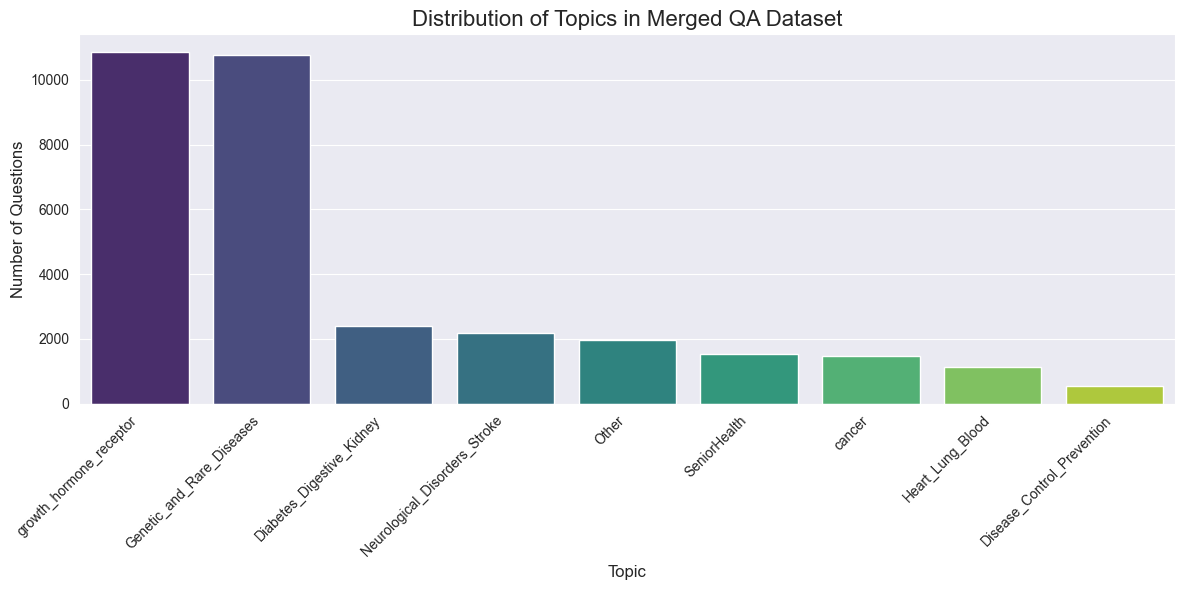

In [5]:
plt.figure(figsize=(12,6))
sns.countplot(data=data_df, x='topic', order=data_df['topic'].value_counts().index, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of Topics in Merged QA Dataset', fontsize=16)
plt.xlabel('Topic', fontsize=12)
plt.ylabel('Number of Questions', fontsize=12)
plt.tight_layout()
plt.savefig('Topicdistirbution.png', dpi=300)
plt.show()

In [55]:
for topic in data_df['topic'].unique():
    print(f"{topic.upper()} EXAMPLES")
    print("=" * 60)

    topic_data = data_df[data_df['topic'] == topic].head(5)

    for idx, row in topic_data.iterrows():
        print(f"Q: {row['Question']}")
        print(f"A: {row['Answer'][:200]}...")  # First 200 characters
        print("-" * 40)


CANCER EXAMPLES
Q: What is (are) Non-Small Cell Lung Cancer ?
A: Key Points
                    - Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung.     - There are several types of non-small cell lung cancer....
----------------------------------------
Q: Who is at risk for Non-Small Cell Lung Cancer? ?
A: Smoking is the major risk factor for non-small cell lung cancer. Anything that increases your chance of getting a disease is called a risk factor. Having a risk factor does not mean that you will get ...
----------------------------------------
Q: What are the symptoms of Non-Small Cell Lung Cancer ?
A: Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Sometimes lung cancer does not cause any signs or symptoms. It may be found during a chest x-ray done ...
----------------------------------------
Q: How to diagnose Non-Small Cell Lung Cancer ?
A: Tests that examine the lungs are u

In [6]:
data_df.columns

Index(['id', 'Question', 'Answer', 'topic'], dtype='object')

count    32812.000000
mean       267.281178
std        327.645341
min          1.000000
25%         97.000000
50%        182.000000
75%        327.000000
max       5644.000000
Name: num_tokens, dtype: float64


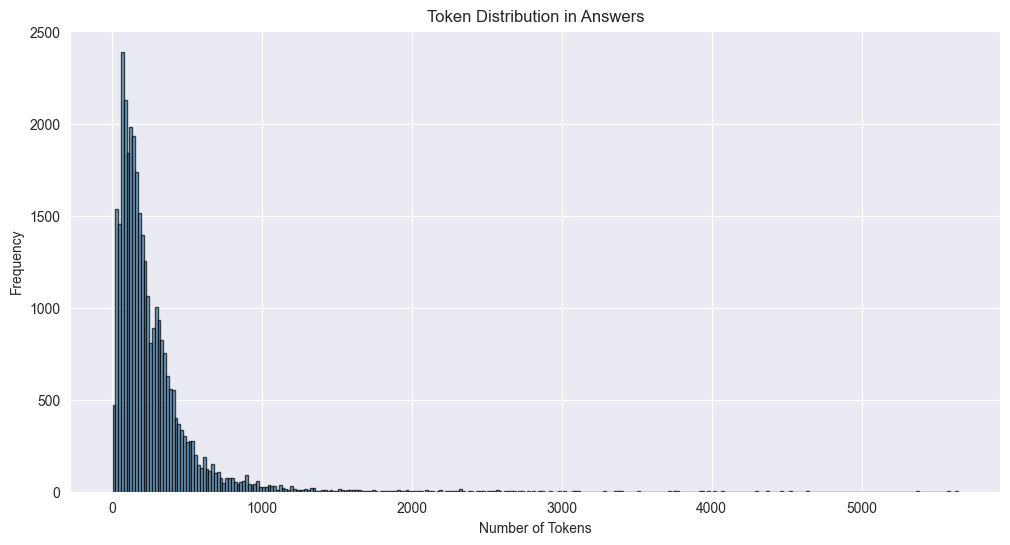

In [84]:
encoding = tiktoken.encoding_for_model("gpt-4o")

# Count tokens for each answer
data_df['num_tokens'] = data_df['Answer'].apply(lambda x: len(encoding.encode(str(x))))

# View distribution statistics
print(data_df['num_tokens'].describe())

data_df['num_tokens'].hist(bins=300, color='steelblue', edgecolor='black', alpha=0.7, figsize=(12, 6))
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Distribution in Answers')
plt.savefig('../images/token_dist.png', dpi=300)
plt.show()

In [79]:
plt.figure(figsize=(12, 6))

# Create histogram with styling
plt.hist(data_df['num_tokens'], bins=50, color='steelblue',
         edgecolor='black', alpha=0.7, linewidth=1.2)

plt.xlabel('Number of Tokens', fontsize=12, fontweight='bold')
plt.ylabel('Frequency', fontsize=12, fontweight='bold')
plt.title('Token Distribution in Answers', fontsize=14, fontweight='bold', pad=20)
plt.grid(axis='y', alpha=0.3, linestyle='--')

KeyError: 'num_tokens'

<Figure size 1200x600 with 0 Axes>

## Cleaning

In [57]:
example = data_df['Answer'][711]
example

"Certain factors affect treatment options and prognosis (chance of recovery). Treatment options depend on:         - The stage of the disease.    - Red blood cell, white blood cell, and platelet blood counts.    - Whether there are signs or symptoms, such as fever, chills, or weight loss.    - Whether the liver, spleen, or lymph nodes are larger than normal.    - The response to initial treatment.    - Whether the CLL has recurred (come back).        The prognosis (chance of recovery) depends on:         - Whether there is a change in the DNA and the type of change, if there is one.    - Whether lymphocytes are spread throughout the bone marrow.    - The stage of the disease.    - Whether the CLL gets better with treatment or has recurred (come back).    - Whether the CLL progresses to lymphoma or prolymphocytic leukemia.    - The patient's general health."

In [58]:
def clean_answer(text):
    result = text.replace('- ', ' ')
    # Remove citation numbers at the end of sentences
    result = re.sub(r'\d+(?=\s|$|[.,;:])', '', result)
    result = ' '.join(result.split())

    return result


clean_answer(example)


"Certain factors affect treatment options and prognosis (chance of recovery). Treatment options depend on: The stage of the disease. Red blood cell, white blood cell, and platelet blood counts. Whether there are signs or symptoms, such as fever, chills, or weight loss. Whether the liver, spleen, or lymph nodes are larger than normal. The response to initial treatment. Whether the CLL has recurred (come back). The prognosis (chance of recovery) depends on: Whether there is a change in the DNA and the type of change, if there is one. Whether lymphocytes are spread throughout the bone marrow. The stage of the disease. Whether the CLL gets better with treatment or has recurred (come back). Whether the CLL progresses to lymphoma or prolymphocytic leukemia. The patient's general health."

In [59]:
data_df['Answer'] = data_df['Answer'].apply(clean_answer)
data_df['Answer'][0]

"Key Points Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. There are several types of non-small cell lung cancer. Smoking is the major risk factor for non-small cell lung cancer. Signs of non-small cell lung cancer include a cough that doesn't go away and shortness of breath. Tests that examine the lungs are used to detect (find), diagnose, and stage non-small cell lung cancer. Certain factors affect prognosis (chance of recovery) and treatment options. For most patients with non-small cell lung cancer, current treatments do not cure the cancer. Non-small cell lung cancer is a disease in which malignant (cancer) cells form in the tissues of the lung. The lungs are a pair of cone-shaped breathing organs in the chest. The lungs bring oxygen into the body as you breathe in. They release carbon dioxide, a waste product of the bodys cells, as you breathe out. Each lung has sections called lobes. The left lung has two lobes. The rig

In [120]:
data_df.columns

Index(['id', 'Question', 'Answer', 'topic'], dtype='object')

## Cleaning data

In [60]:
num_qa_duplicates = data_df.duplicated(subset=['Question', 'Answer']).sum()
print(f"Number of duplicated question-answer pairs: {num_qa_duplicates}")

duplicate_qa = data_df[data_df.duplicated(subset=['Question', 'Answer'], keep=False)] #this means the exact sames AND answer are present in the dataset
print("Duplicated question-answer pairs:")
print(duplicate_qa)
data_df = data_df.drop_duplicates(subset=['Question', 'Answer'], keep='first')
data_df


Number of duplicated question-answer pairs: 16454
Duplicated question-answer pairs:
                                                Question  \
0             What is (are) Non-Small Cell Lung Cancer ?   
1       Who is at risk for Non-Small Cell Lung Cancer? ?   
2      What are the symptoms of Non-Small Cell Lung C...   
3           How to diagnose Non-Small Cell Lung Cancer ?   
4      What is the outlook for Non-Small Cell Lung Ca...   
...                                                  ...   
32807                          What is (are) Dry Mouth ?   
32808                          What is (are) Dry Mouth ?   
32809            What are the treatments for Dry Mouth ?   
32810                          What is (are) Dry Mouth ?   
32811                          What is (are) Dry Mouth ?   

                                                  Answer         topic  \
0      Key Points Non-small cell lung cancer is a dis...        cancer   
1      Smoking is the major risk factor for non

,Question,Answer,topic,num_tokens
0,What is (are) Non-Small Cell Lung Cancer ?,Key Points Non-small cell lung cancer is a dis...,cancer,679
1,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...,cancer,323
2,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...,cancer,167
3,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...,cancer,846
4,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...,cancer,128
...,...,...,...,...
29969,What is (are) COPD ?,COPD (chronic obstructive pulmonary disease) m...,Other,194
29970,What is (are) Complex Regional Pain Syndrome ?,Complex regional pain syndrome (CRPS) is a chr...,Other,203
29971,What is (are) Kidney Stones ?,A kidney stone is a solid piece of material th...,Other,229
29972,What is (are) Meniere's Disease ?,Meniere's disease is a disorder of the inner e...,Other,249


In [61]:
data_df.isna().sum()

Question      0
Answer        0
topic         0
num_tokens    0
dtype: int64

count    16358.000000
mean       253.655459
std        304.624350
min          1.000000
25%         90.000000
50%        175.000000
75%        315.000000
max       5260.000000
Name: num_tokens, dtype: float64


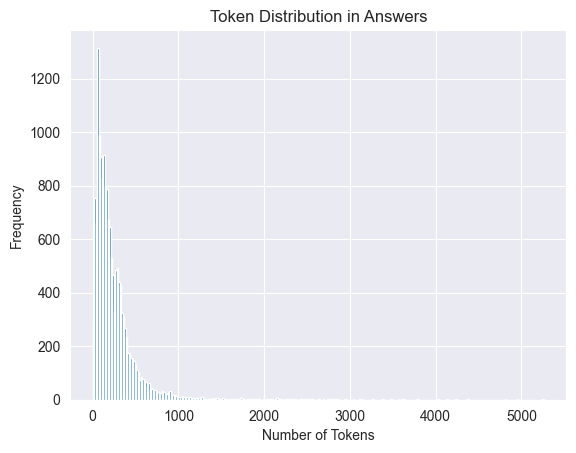

In [66]:
encoding = tiktoken.encoding_for_model("gpt-4o")

# Count tokens for each answer
data_df['num_tokens'] = data_df['Answer'].apply(lambda x: len(encoding.encode(str(x))))

# View distribution statistics
print(data_df['num_tokens'].describe())

data_df['num_tokens'].hist(bins=300)
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Token Distribution in Answers')
#plt.savefig('../images/token_dist.png', dpi=300)
plt.show()

In [40]:
data_df.topic.value_counts()

topic
growth_hormone_receptor          5430
Genetic_and_Rare_Diseases        5388
Diabetes_Digestive_Kidney        1144
Neurological_Disorders_Stroke    1088
Other                             981
SeniorHealth                      769
cancer                            729
Heart_Lung_Blood                  559
Disease_Control_Prevention        270
Name: count, dtype: int64

In [51]:
data_df.columns

Index(['id', 'topic', 'Question', 'Answer', 'num_tokens'], dtype='object')

In [67]:
data_df[data_df['num_tokens'] >1000].topic.value_counts()


topic
cancer                        161
Diabetes_Digestive_Kidney      58
Heart_Lung_Blood               58
SeniorHealth                   39
Genetic_and_Rare_Diseases      28
Disease_Control_Prevention     11
Name: count, dtype: int64

In [69]:
data_df[data_df['num_tokens'] >1000]

,Question,Answer,topic,num_tokens
5,What are the stages of Non-Small Cell Lung Can...,Key Points After lung cancer has been diagnose...,cancer,2962
6,What are the treatments for Non-Small Cell Lun...,Key Points There are different types of treatm...,cancer,4127
13,What are the stages of Uterine Sarcoma ?,Key Points After uterine sarcoma has been diag...,cancer,1497
14,What are the treatments for Uterine Sarcoma ?,Key Points There are different types of treatm...,cancer,1583
22,What are the treatments for Extragonadal Germ ...,Key Points There are different types of treatm...,cancer,1575
...,...,...,...,...
19692,How to prevent High Blood Pressure ?,Steps You Can Take You can take steps to preve...,SeniorHealth,1299
19693,What are the symptoms of High Blood Pressure ?,"High blood pressure is often called the ""silen...",SeniorHealth,1579
19708,What is (are) Hearing Loss ?,Hearing loss is a common problem caused by noi...,SeniorHealth,1006
19711,What are the treatments for Hearing Loss ?,Your doctor can recommend strategies to help r...,SeniorHealth,1401


In [71]:
data_df = data_df[data_df['num_tokens'] <1000]

In [72]:
## adding index for future retrieval
data_df = data_df.reset_index(drop=True)
data_df['id'] = data_df.index +1
order = ['id', 'Question', 'Answer', 'topic']

data_df = data_df[order]
data_df

,id,Question,Answer,topic
0,1,What is (are) Non-Small Cell Lung Cancer ?,Key Points Non-small cell lung cancer is a dis...,cancer
1,2,Who is at risk for Non-Small Cell Lung Cancer? ?,Smoking is the major risk factor for non-small...,cancer
2,3,What are the symptoms of Non-Small Cell Lung C...,Signs of non-small cell lung cancer include a ...,cancer
3,4,How to diagnose Non-Small Cell Lung Cancer ?,Tests that examine the lungs are used to detec...,cancer
4,5,What is the outlook for Non-Small Cell Lung Ca...,Certain factors affect prognosis (chance of re...,cancer
...,...,...,...,...
15995,15996,What is (are) COPD ?,COPD (chronic obstructive pulmonary disease) m...,Other
15996,15997,What is (are) Complex Regional Pain Syndrome ?,Complex regional pain syndrome (CRPS) is a chr...,Other
15997,15998,What is (are) Kidney Stones ?,A kidney stone is a solid piece of material th...,Other
15998,15999,What is (are) Meniere's Disease ?,Meniere's disease is a disorder of the inner e...,Other


In [76]:
data_df = data_df[['id', 'topic', 'Question', 'Answer']]

In [77]:
data_df.to_csv('../Data_csvs/data_v1.csv', index=False)

## Chunking the answers - No point of doing it for less than 400 records over a 16000 dataset. it's overcomplicating the solution and the evaluation- gold standard dataset creation.. etc, + we should evaluate the retrieval on chunk and answers level

In [19]:
# from langchain.text_splitter import RecursiveCharacterTextSplitter
# splitter = RecursiveCharacterTextSplitter(
#     chunk_size=500,
#     chunk_overlap=50    #  context continuity
# )
#
# def chunk_texts(df):
#     rows = []
#     for _, row in df.iterrows():
#         answer = row['Answer']
#         chunks = splitter.split_text(answer)
#         for i, chunk in enumerate(chunks):
#             rows.append({
#                 "doc_id": row['id'],
#                 "chunk_index": i,                     # chunk order
#                 "topic": row['topic'],
#                 "question": row['Question'],          # original question
#                 "original_answers": row["Answer"],
#                 "chunk_text": chunk                   # the actual chunk
#             })
#     return pd.DataFrame(rows)
#
# df = chunk_texts(data_df)

In [ ]:
#df.to_csv('../Data_csvs/data.csv', index=False)